In [1]:
%load_ext nb_black
%matplotlib inline
from IPython.display import set_matplotlib_formats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import logging
import jax
from math import log, exp, sqrt
from sim import sim_and_fit, sim_wf

# from estimate import posterior_decoding, sample_paths
from common import Observation
from plotting import plot_summary, compute_rmse, bias_variance
from itertools import combinations_with_replacement, product

rng = np.random.default_rng()

N_SIMULATIONS = 100

set_matplotlib_formats("svg")

<IPython.core.display.Javascript object>

## Define standard models for demography and selection 

In [2]:
s_mdls = [
    {"s": [0.01] * 100, "h": [0.5] * 100, "f0": 0.1},
    #    {"s": [0.02] * 50 + [-0.02] * 50, "h": [0.5] * 100, "f0": 0.1},
    {
        "s": [0.02 * np.cos(np.pi * x / 99) for x in range(100)],
        "h": [0.5] * 100,
        "f0": 0.1,
    },
    {"s": (([0.02] * 20 + [-0.02] * 20) * 3)[:100], "h": [0.5] * 100, "f0": 0.5},
]
s_names = ["const", "switch", "fluc"]

gr = exp(log(10) / 100)
Ne_mdls = [
    [10000] * 100,  # constant
    [round(10000 * gr ** (10 * int(x / 10))) for x in range(100)],  # exp growth
    [10000] * 40 + [1000] * 20 + [10000] * 40,  # bottleneck
]
Ne_names = ["const", "exp", "bottle"]

<IPython.core.display.Javascript object>

## Performance under standard models

In [ ]:
fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(12, 12))

axs[0][0].axis("off")

optimal_lambda = [5, 4, 3]

std_res = pd.DataFrame(columns=["Scenario", "Demog", "Select", "iter", "RMSE"])

for i in range(3):
    axs[i + 1][0].plot(range(1, 101), Ne_mdls[i], color="black")

for j in range(3):
    axs[0][j + 1].plot(range(1, 101), s_mdls[j]["s"], color="black")

std_res = []

for i in range(3):
    for j in range(3):
        res = []
        for seed in range(N_SIMULATIONS):
            this_res = sim_and_fit(
                s_mdls[j], seed=12345 + seed, lam=10 ** optimal_lambda[j], Ne=Ne_mdls[i]
            )
            res.append(this_res)
            rmse = compute_rmse(this_res["s_hat"], s_mdls[i]["s"])
            std_res.append(
                {
                    "s_mdl": s_names[i],
                    "Ne_mdl": Ne_names[i],
                    "iter": seed,
                    "sampling": "100-10",
                    "rmse": rmse,
                }
            )
        x, y = zip(*[(range(len(rr["s_hat"])), rr["s_hat"]) for rr in res])
        plot_summary(axs[i + 1][j + 1], x, y, s_mdls[j]["s"])

std_res = pd.DataFrame(std_res)

## Performance if we incorrectly assume that Ne is constant 

In [ ]:
fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(12, 9))

axs[0][0].axis("off")
optimal_lambda = [5, 4, 3]

for i in range(1, 3):
    axs[i][0].plot(range(1, 101), Ne_mdls[i], color="black")

for j in range(3):
    axs[0][j + 1].plot(range(1, 101), s_mdls[j]["s"], color="black")

for i in range(3):
    for j in range(1, 3):
        res = []
        for seed in range(N_SIMULATIONS):
            res.append(
                sim_and_fit(
                    s_mdls[i],
                    seed=12345 + seed,
                    lam=10 ** optimal_lambda[i],
                    Ne=Ne_mdls[j],
                    Ne_fit=[10000] * len(s_mdls[i]["s"]),
                )
            )
        x, y = zip(*[(range(len(rr["s_hat"])), rr["s_hat"]) for rr in res])
        plot_summary(axs[j][i + 1], x, y, s_mdls[i]["s"])

## See how RMSE changes as sample size and frequency change

In [ ]:
ns = [1, 10, 100]
ks = [5, 10, 20]
size_res = []  # total results to save

fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(12, 12))
optimal_lambda = [5, 4, 3]

axs[0][0].axis("off")
std_res = pd.DataFrame(columns=["Scenario", "Demog", "Select", "iter", "RMSE"])
for i in range(3):
    axs[i + 1][0].plot(range(1, 101), Ne_mdls[i], color="black")
for j in range(3):
    axs[0][j + 1].plot(range(1, 101), s_mdls[j]["s"], color="black")


for i, j in product(range(3), range(3)):
    plot_res = []  # results to make this subplot
    for nn, kk, seed in product(ns, ks, range(N_SIMULATIONS)):
        this_res = sim_and_fit(
            s_mdls[j],
            seed=12345 + seed,
            lam=10 ** optimal_lambda[j],
            Ne=Ne_mdls[i],
            n=nn,
            k=kk,
        )
        rmse = compute_rmse(this_res["s_hat"], s_mdls[j]["s"])
        plot_res.append(
            {
                "s_mdl": s_names[j],
                "Ne_mdl": Ne_names[j],
                "iter": seed,
                "sampling": str(nn) + "-" + str(kk),
                "rmse": rmse,
            }
        )

    size_res.extend(plot_res)
    plot_res = pd.DataFrame(plot_res)
    axs[i + 1][j + 1].tick_params(labelsize=6)
    axs[i + 1][j + 1].xaxis.label.set_visible(False)
    axs[i + 1][j + 1].title.set_visible(False)
    plot_res.boxplot(ax=axs[i + 1][j + 1], by="sampling", column=["rmse"])

fig.suptitle(None)
size_res = pd.DataFrame(size_res)

## Smoothing parameter

In [ ]:
log10_lambda = [1, 2, 2.5, 3, 3.5, 4, 4.5, 5, 6]
lam_res = []  # total results to save

fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(12, 12))

axs[0][0].axis("off")
std_res = pd.DataFrame(columns=["Scenario", "Demog", "Select", "iter", "RMSE"])
for i in range(3):
    axs[i + 1][0].plot(range(1, 101), Ne_mdls[i], color="black")
for j in range(3):
    axs[0][j + 1].plot(range(1, 101), s_mdls[j]["s"], color="black")

lam_res = []
for i, j in product(range(3), range(3)):
    plot_res = []  # results to make this subplot
    for lam in log10_lambda:
        this_res = []
        for seed in range(N_SIMULATIONS):
            this_res.append(
                sim_and_fit(s_mdls[j], seed=12345 + seed, lam=10 ** lam, Ne=Ne_mdls[i])
            )

        x, y = zip(*[(range(len(rr["s_hat"])), rr["s_hat"]) for rr in this_res])
        b, v, m = bias_variance(y, s_mdls[j]["s"])
        plot_res.append(
            {
                "s_mdl": s_names[j],
                "Ne_mdl": Ne_names[j],
                "lambda": lam,
                "rmse": m,
                "rbias": b,
                "rvar": v,
            }
        )

    lam_res.extend(plot_res)
    plot_res = pd.DataFrame(plot_res)
    axs[i + 1][j + 1].tick_params(labelsize=6)
    axs[i + 1][j + 1].xaxis.label.set_visible(False)
    axs[i + 1][j + 1].title.set_visible(False)
    axs[i + 1][j + 1].plot(plot_res["lambda"], plot_res["rmse"], color="tab:red")
    axs[i + 1][j + 1].plot(plot_res["lambda"], plot_res["rbias"], color="tab:green")
    axs[i + 1][j + 1].plot(plot_res["lambda"], plot_res["rvar"], color="tab:blue")


fig.suptitle(None)
lam_res = pd.DataFrame(lam_res)

## Simulations using the sampling distribution of the ancient European samples

In [4]:
samples = pd.read_csv("aadr_1240k_EUR_4500BP_1kg_meta.txt", sep="\t")
samples["GenBP"] = samples.DateBP // 29  # assume 29 years per-generation
counts = samples.GenBP.value_counts().sort_index()
sizes, times = counts.values, np.array(counts.index)

T = times[-1]
s2_mdls = [
    {"s": [0.01] * T, "h": [0.5] * T, "f0": 0.1},
    {
        "s": [0.02 * np.cos(np.pi * x / (T - 1)) for x in range(T)],
        "h": [0.5] * T,
        "f0": 0.1,
    },
    {"s": (([0.02] * 20 + [-0.02] * 20) * 6)[:T], "h": [0.5] * T, "f0": 0.5},
]
gr = exp(log(100) / T)
Ne_mdl2 = [round(10000 * gr ** (10 * int(x / 10))) for x in range(T)]  # exp growth

<IPython.core.display.Javascript object>

Text(0.5, 0.98, '')

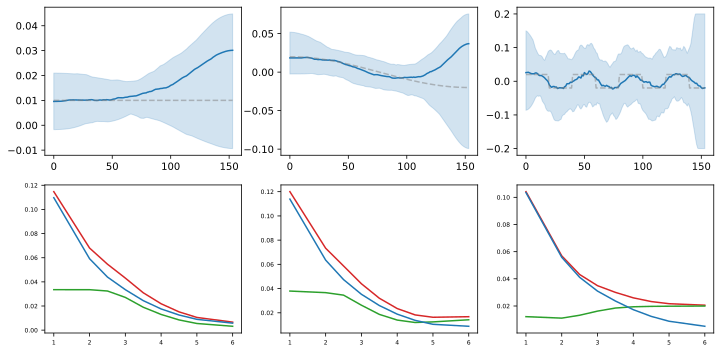

<IPython.core.display.Javascript object>

In [5]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(12, 6))

optimal_lambda = [5, 4, 2]


for j in range(3):
    res = []
    for seed in range(N_SIMULATIONS):
        this_res = sim_and_fit(s2_mdls[j], seed=12345 + seed, lam=10**optimal_lambda[j], Ne=Ne_mdl2, k=times, n=sizes)
        res.append(this_res)
    x, y = zip(*[(range(len(rr["s_hat"])), rr["s_hat"]) for rr in res])
    plot_summary(axs[0][j], x, y, s2_mdls[j]["s"])

log10_lambda = [1, 2, 2.5, 3, 3.5, 4, 4.5, 5, 6]

for j in range(3):
    plot_res = []  # results to make this subplot
    for lam in log10_lambda:
        this_res = []
        for seed in range(N_SIMULATIONS):
            this_res.append(
                sim_and_fit(s2_mdls[j], seed=12345 + seed, lam=10 ** lam, Ne=10000, k=times, n=sizes)
            )

        x, y = zip(*[(range(len(rr["s_hat"])), rr["s_hat"]) for rr in this_res])
        b, v, m = bias_variance(y, s2_mdls[j]["s"])
        plot_res.append(
            {
                "s_mdl": s_names[j],
                "Ne_mdl": "Exp2",
                "lambda": lam,
                "rmse": m,
                "rbias": b,
                "rvar": v,
            }
        )


    plot_res = pd.DataFrame(plot_res)
    axs[1][j].tick_params(labelsize=6)
    axs[1][j].xaxis.label.set_visible(False)
    axs[1][j].title.set_visible(False)
    axs[1][j].plot(plot_res["lambda"], plot_res["rmse"], color="tab:red")
    axs[1][j].plot(plot_res["lambda"], plot_res["rbias"], color="tab:green")
    axs[1][j].plot(plot_res["lambda"], plot_res["rvar"], color="tab:blue")


fig.suptitle(None)
